In [2]:
# Import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

# Understand the problem

### Understand The Problem Type

As you've just seen, the first step of the solution workflow is to skim through the problem statement. Your goal now is to determine data types available as well as the problem type for the Avito Demand Prediction Challenge. The evaluation metric in this competition is the Root Mean Squared Error. The problem definition is presented below.<br>
<br>
<i>In this Kaggle competition, Avito is challenging you to predict demand for an online advertisement based on its full description (price, title, images, etc.), its context (geo position, similar ads already posted) and historical demand for similar ads in the past. </i>

<b> What problem type are you facing, and what data do you have at your disposal?</b><br>
<br>
#### Answer: This is a regression problem with tabular, time series, image and text data.<br>
This competition contains a mix of various structured and unstructured data.

### Define a competition metric

In [3]:
sample = pd.read_csv('sample_reg_true_pred.csv')
y_regression_true, y_regression_pred = sample['true'].to_numpy(), sample['pred'].to_numpy()

In [4]:
# Import MSE from sklearn
from sklearn.metrics import mean_squared_error

# Define your own MSE function
def own_mse(y_true, y_pred):
  	# Raise differences to the power of 2
    squares = np.power(y_true - y_pred, 2)
    # Find mean over all observations
    err = np.mean(squares)
    return err

print('Sklearn MSE: {:.5f}. '.format(mean_squared_error(y_regression_true, y_regression_pred)))
print('Your MSE: {:.5f}. '.format(own_mse(y_regression_true, y_regression_pred)))

Sklearn MSE: 0.15418. 
Your MSE: 0.15418. 


In [5]:
sample_class = pd.read_csv('sample_class_true_pred.csv')
y_classification_true, y_classification_pred = sample_class['true'].to_numpy(), sample_class['pred'].to_numpy()

In [6]:
# Import log_loss from sklearn
from sklearn.metrics import log_loss

# Define your own LogLoss function
def own_logloss(y_true, prob_pred):
  	# Find loss for each observation
    terms = y_true * np.log(prob_pred) + (1 - y_true) * np.log(1 - prob_pred)
    # Find mean over all observations
    err = np.mean(terms) 
    return -err

print('Sklearn LogLoss: {:.5f}'.format(log_loss(y_classification_true, y_classification_pred)))
print('Your LogLoss: {:.5f}'.format(own_logloss(y_classification_true, y_classification_pred)))

Sklearn LogLoss: 1.10801
Your LogLoss: 1.10801


# Initial EDA

### EDA statistics

In [7]:
train = pd.read_csv('taxi_train_chapter_4.csv')
test = pd.read_csv('taxi_test_chapter_4.csv')

In [8]:
# Part 1
# Shapes of train and test data
print('Train shape:', train.shape)
print('Test shape:', test.shape)

# Train head()
print(train.head())

# Part 2
# Describe the target variable
print(train.fare_amount.describe())

# Train distribution of passengers within rides
print(train.passenger_count.value_counts())

Train shape: (20000, 8)
Test shape: (9914, 7)
   id  fare_amount          pickup_datetime  pickup_longitude  \
0   0          4.5  2009-06-15 17:26:21 UTC        -73.844311   
1   1         16.9  2010-01-05 16:52:16 UTC        -74.016048   
2   2          5.7  2011-08-18 00:35:00 UTC        -73.982738   
3   3          7.7  2012-04-21 04:30:42 UTC        -73.987130   
4   4          5.3  2010-03-09 07:51:00 UTC        -73.968095   

   pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  
0        40.721319         -73.841610         40.712278                1  
1        40.711303         -73.979268         40.782004                1  
2        40.761270         -73.991242         40.750562                2  
3        40.733143         -73.991567         40.758092                1  
4        40.768008         -73.956655         40.783762                1  
count    20000.000000
mean        11.303321
std          9.541637
min         -3.000000
25%          6.000000
50%

### EDA plots I

In [9]:
# Given
def haversine_distance(train):
    
    data = [train]
    lat1, long1, lat2, long2 = 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'
    
    for i in data:
        R = 6371  #radius of earth in kilometers
        #R = 3959 #radius of earth in miles
        phi1 = np.radians(i[lat1])
        phi2 = np.radians(i[lat2])
    
        delta_phi = np.radians(i[lat2]-i[lat1])
        delta_lambda = np.radians(i[long2]-i[long1])
    
        #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
        a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    
        #c = 2 * atan2( √a, √(1−a) )
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
        #d = R*c
        d = (R * c) #in kilometers
        
    return d

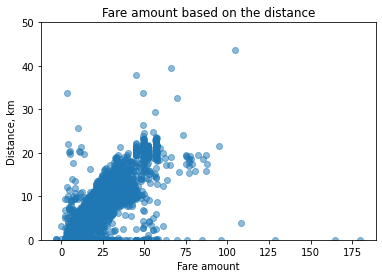

In [10]:
# Calculate the ride distance
train['distance_km'] = haversine_distance(train)

# Draw a scatterplot
plt.scatter(x = train["fare_amount"], y = train["distance_km"], alpha = 0.5)
plt.xlabel('Fare amount')
plt.ylabel('Distance, km')
plt.title('Fare amount based on the distance')

# Limit on the distance
plt.ylim(0, 50)
plt.show()

### EDA plots II

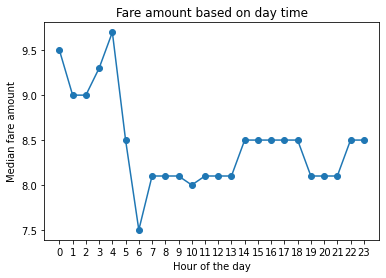

In [11]:
# Create hour feature
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
train['hour'] = train.pickup_datetime.dt.hour

# Find median fare_amount for each hour
hour_price = train.groupby('hour', as_index = False)['fare_amount'].median()

# Plot the line plot
plt.plot(hour_price['hour'], hour_price['fare_amount'], marker='o')
plt.xlabel('Hour of the day')
plt.ylabel('Median fare amount')
plt.title('Fare amount based on day time')
plt.xticks(range(24))
plt.show()

# Local validation

### K-fold cross-validation

In [12]:
train = pd.read_csv('twosigma_rental_train.csv')

In [13]:
# Import KFold
from sklearn.model_selection import KFold

# Create a KFold object
kf = KFold(n_splits = 3, shuffle = True, random_state = 123)

# Loop through each split
fold = 0
for train_index, test_index in kf.split(train):
    # Obtain training and testing folds
    cv_train, cv_test = train.iloc[train_index], train.iloc[test_index]
    print('Fold: {}'.format(fold))
    print('CV train shape: {}'.format(cv_train.shape))
    print('Medium interest listings in CV train: {}\n'.format(sum(cv_train.interest_level == 'medium')))
    fold += 1

Fold: 0
CV train shape: (666, 9)
Medium interest listings in CV train: 175

Fold: 1
CV train shape: (667, 9)
Medium interest listings in CV train: 165

Fold: 2
CV train shape: (667, 9)
Medium interest listings in CV train: 162



### Stratified K-fold

In [15]:
# Import StratifiedKFold
from sklearn.model_selection import StratifiedKFold

# Create a StratifiedKFold object
str_kf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 123)

# Loop through each split
fold = 0
for train_index, test_index in str_kf.split(train, train['interest_level']):
    # Obtain training and testing folds
    cv_train, cv_test = train.iloc[train_index], train.iloc[test_index]
    print('Fold: {}'.format(fold))
    print('CV train shape: {}'.format(cv_train.shape))
    print('Medium interest listings in CV train: {}\n'.format(sum(cv_train.interest_level == 'medium')))
    fold += 1

Fold: 0
CV train shape: (666, 9)
Medium interest listings in CV train: 167

Fold: 1
CV train shape: (667, 9)
Medium interest listings in CV train: 167

Fold: 2
CV train shape: (667, 9)
Medium interest listings in CV train: 168



# Validation usage

### Time K-fold

In [16]:
train = pd.read_csv('demand_forecasting_train_1_month.csv')

In [18]:
from sklearn.model_selection import TimeSeriesSplit

# Create TimeSeriesSplit object
time_kfold = TimeSeriesSplit(n_splits = 3)

# Sort train data by date
train = train.sort_values("date")

# Iterate through each split
fold = 0
for train_index, test_index in time_kfold.split(train):
    cv_train, cv_test = train.iloc[train_index], train.iloc[test_index]
    
    print('Fold :', fold)
    print('Train date range: from {} to {}'.format(cv_train.date.min(), cv_train.date.max()))
    print('Test date range: from {} to {}\n'.format(cv_test.date.min(), cv_test.date.max()))
    fold += 1

Fold : 0
Train date range: from 2017-12-01 to 2017-12-08
Test date range: from 2017-12-08 to 2017-12-16

Fold : 1
Train date range: from 2017-12-01 to 2017-12-16
Test date range: from 2017-12-16 to 2017-12-24

Fold : 2
Train date range: from 2017-12-01 to 2017-12-24
Test date range: from 2017-12-24 to 2017-12-31



### Overall validation score

In [20]:
from sklearn.ensemble import RandomForestRegressor

def get_fold_mse(train, kf):
    mse_scores = []
    
    for train_index, test_index in kf.split(train):
        fold_train, fold_test = train.loc[train_index], train.loc[test_index]

        # Fit the data and make predictions
        # Create a Random Forest object
        rf = RandomForestRegressor(n_estimators=10, random_state=123)

        # Train a model
        rf.fit(X=fold_train[['store', 'item']], y=fold_train['sales'])

        # Get predictions for the test set
        pred = rf.predict(fold_test[['store', 'item']])
    
        fold_score = round(mean_squared_error(fold_test['sales'], pred), 5)
        mse_scores.append(fold_score)
        
    return mse_scores



In [23]:
# Part 1
from sklearn.model_selection import TimeSeriesSplit

# Sort train data by date
train = train.sort_values('date')

# Initialize 3-fold time cross-validation
kf = TimeSeriesSplit(n_splits = 3)

# Get MSE scores for each cross-validation split
mse_scores = get_fold_mse(train, kf)

print('Mean validation MSE: {:.5f}'.format(np.mean(mse_scores)))


# Part 2
print('MSE by fold: {}'.format(mse_scores))


# Part 3
print('Overall validation MSE: {:.5f}'.format(np.mean(mse_scores) + np.std(mse_scores)))


Mean validation MSE: 955.49186
MSE by fold: [890.30336, 961.65797, 1014.51424]
Overall validation MSE: 1006.38784
